# SVM with SMOTE Balanced Data -- RBF Kernel different C-Values and Gamma-Values

In [1]:
import pickle
import numpy as np
from datetime import datetime as dt
import itertools

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
# import dataset from pickle
X_train, X_test, y_train, y_test = pickle.load( open( "../../pickles/intercorr_app2_MinMaxScaler_smote_20210711_214137.pickle", "rb" ) )

#### Convert pandas dataframe to series

In [3]:
y_train = y_train.squeeze(axis=1)
y_test = y_test.squeeze(axis=1)

### Define Scoring functions for cross_validation

In [3]:
scoring = {'accuracy': 'accuracy',
           'bal_acc' : 'balanced_accuracy',
           'f1' : 'f1',
           'recall': 'recall',
           'precision' : 'precision',
           'roc_auc' : 'roc_auc',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [4]:
def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=StratifiedShuffleSplit(8)):
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}

### Evaluate with Test Data

In [5]:
def calc_test_scores(y_test, y_predicted):
    test_scores = {'Balanced Accuracy' : balanced_accuracy_score(y_test, y_predicted),
                   'Accuracy': accuracy_score(y_test, y_predicted),
                   'ROC_AUC': roc_auc_score(y_test, y_predicted),
                   'f1_score': f1_score(y_test, y_predicted),
                   'recall_score' : recall_score(y_test, y_predicted),
                   'specificity_score' : recall_score(y_test, y_predicted, pos_label=0),
                   'precision_score' : precision_score(y_test, y_predicted),
    }
    return test_scores


def validate_against_test(obj, X_test, y_test):
    y_predicted = obj.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    scores = calc_test_scores(y_test, y_predicted)
    return scores, cm

### Calculations

In [6]:
# create a series of C-Values, where the gaps between successive C-values get larger
def cseries(init, limit):
    counter = 0
    new = init
    l = [0]
    while True:
        l.append(new)
        new = l[counter]/1.5+l[counter+1]
        counter += 1
        if new >= limit*1.5:
            break
    cparam = l[2:]

    return cparam

# create a series of gamma-Values, where the gaps between successive gamma-values get larger
def gseries(init, limit):
    counter = 0
    new = init
    l = [0]
    while True:
        l.append(new)
        new = l[counter]/1.5+l[counter+1]
        counter += 1
        if new >= limit*1.5:
            break
    gparam = l[2:]

    return gparam

In [7]:
start = dt.now()

allres = []
cparam = cseries(0.1, 100) 
gparam = gseries(0.0001, 10)

paramcombs = list(itertools.product(cparam, gparam))

print(len(paramcombs))
jobs = -1
rstate = 78
kern = 'rbf'

val_res=[]



for para in paramcombs:
    clf = SVC(kernel= kern, C=para[0], gamma=para[1])
    cross_results = average_score_on_cross_val_classification(clf, X_train, y_train)
    clf = clf.fit(X_train, y_train)
    scores_testdata, confmatrix = validate_against_test(clf, X_test, y_test)
    val_res.append((cross_results, scores_testdata, confmatrix,para))
allres.append(val_res)


    
end = dt.now()
diff = end-start

print('Duration of calculations: %s' %diff)

640
Duration of calculations: 0:09:39.859612


### Save results for export from cluster

In [24]:
out = (allres)
timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
filename = '../../pickles/SVM_MinMax_rbf_c_and_gamma_smote_%s.pickle' %timestamp
filehandler = open(filename, 'wb')
pickle.dump(out, filehandler)

### Plot calculations

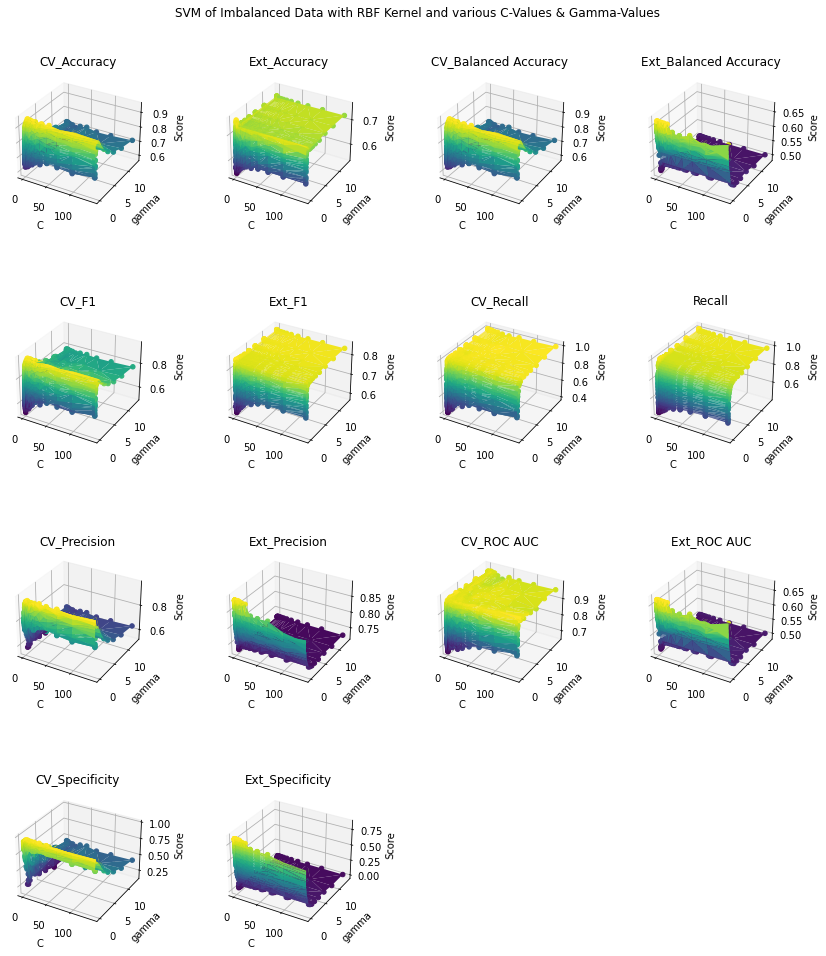

In [9]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget


x = np.array([r[3][0] for r in allres[0]])
y = np.array([r[3][1] for r in allres[0]])
z1 = np.array([r[0]['test_accuracy'] for r in allres[0]])
z2 = np.array([r[1]['Accuracy'] for r in allres[0]])
z3 = np.array([r[0]['test_bal_acc'] for r in allres[0]])
z4 = np.array([r[1]['Balanced Accuracy'] for r in allres[0]])
z5 = np.array([r[0]['test_f1'] for r in allres[0]])
z6 = np.array([r[1]['f1_score'] for r in allres[0]])
z7 = np.array([r[0]['test_recall'] for r in allres[0]])
z8 = np.array([r[1]['recall_score'] for r in allres[0]])
z9 = np.array([r[0]['test_precision'] for r in allres[0]])
z10 = np.array([r[1]['precision_score'] for r in allres[0]])
z11 = np.array([r[0]['test_roc_auc'] for r in allres[0]])
z12 = np.array([r[1]['ROC_AUC'] for r in allres[0]])
z13 = np.array([r[0]['test_specificity'] for r in allres[0]])
z14 = np.array([r[1]['specificity_score'] for r in allres[0]])


z = [z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14]
titles = ['CV_Accuracy', 'Ext_Accuracy', 'CV_Balanced Accuracy', 'Ext_Balanced Accuracy', 'CV_F1', 'Ext_F1',  'CV_Recall', 'Recall',
          'CV_Precision', 'Ext_Precision', 'CV_ROC AUC', 'Ext_ROC AUC', 'CV_Specificity', 'Ext_Specificity']
fig = plt.figure(figsize=(13,15))
plt.subplots_adjust(left=0.05, bottom=None, right=None, top=0.92, wspace=0.3, hspace=0.7)

fig.suptitle('SVM of Imbalanced Data with RBF Kernel and various C-Values & Gamma-Values')
ct = 0
ct2 = 0
for zp in range(len(z)):
    #pos = int(''.join(map(str, [(len(z)//2)+1, 2 , '%i' %(zp+1)])))
    #ax = fig.add_subplot(pos, projection='3d')
    ax = plt.subplot2grid((4,4), (ct2,ct),  projection='3d')
    ax.scatter(x, y, z[zp], c=z[zp], alpha=1, cmap='viridis')
    ax.plot_trisurf(x, y, z[zp], cmap='viridis', edgecolor='none')
    ax.set_title('%s'%titles[zp])
    ax.set_xlabel('C')
    ax.set_ylabel('gamma')
    ax.set_zlabel('Score')
    ct +=1
    if ct == 4:
        ct2 += 1
        ct = 0
plt.show()

### Single Plot for closer investigation

In [10]:
##from mpl_toolkits.mplot3d import axes3d
##import matplotlib.pyplot as plt
##import numpy as np
###if using a Jupyter notebook, include:
###%matplotlib notebook
##%matplotlib inline
###%matplotlib widget
##
### Give data to plot by r[int][0/1]
##x = np.array([r[3][0] for r in allres[0]])
##y = np.array([r[3][1] for r in allres[0]])
##z1 = np.array([r[0]['test_accuracy'] for r in allres[0]])
##z2 = np.array([r[1]['Accuracy'] for r in allres[0]])
##z3 = np.array([r[0]['test_bal_acc'] for r in allres[0]])
##z4 = np.array([r[1]['Balanced Accuracy'] for r in allres[0]])
##z5 = np.array([r[0]['test_f1'] for r in allres[0]])
##z6 = np.array([r[1]['f1_score'] for r in allres[0]])
##z7 = np.array([r[0]['test_recall'] for r in allres[0]])
##z8 = np.array([r[1]['recall_score'] for r in allres[0]])
##z9 = np.array([r[0]['test_precision'] for r in allres[0]])
##z10 = np.array([r[1]['precision_score'] for r in allres[0]])
##z11 = np.array([r[0]['test_roc_auc'] for r in allres[0]])
##z12 = np.array([r[1]['ROC_AUC'] for r in allres[0]])
##z13 = np.array([r[0]['test_specificity']for r in allres[0]])
###z13 = np.array([(r[0]['test_specificity']/4)+0.7 for r in allres[0]])
##z14 = np.array([r[1]['specificity_score'] for r in allres[0]])
##
##Z = z5
##
###plt.subplots_adjust(left=0.05, bottom=None, right=None, top=0.92, wspace=0.3, hspace=0.7)
##fig = plt.figure(figsize=(13,15))
###fig.suptitle('SVM of Imbalanced Data with RBF Kernel and various C-Values & Gamma-Values')
##ax = fig.gca(projection='3d')
##
##ax.scatter(x, y, Z, c=Z, alpha=1, cmap='viridis')
##ax.plot_trisurf(x, y, Z,
##                    cmap='viridis', edgecolor='none');
###ax2 = ax.twinz()
###ax.plot_trisurf(x, y, z13,
###                    cmap='plasma', edgecolor='none');
###ax.set_zlim([0,1])
###ax.set_title('Scoring parameter')
##ax.set_xlabel('C')
##ax.set_ylabel('gamma')
##ax.set_zlabel('Score')
##
##plt.show()

### Simple Gridsearch to find ideal C- and Gamma-Values

In [11]:
# Define grid and scoring
grid = {'C' : cseries(0.1, 100),
        'gamma' : gseries(0.0001, 10),
        }

scoring = {'f1' : 'f1',
           'recall': 'recall',
           #'precision' : 'precision',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [12]:
grid_results = {}

In [13]:
kern = 'rbf'
start = dt.now()
for sco, sc in scoring.items():
    clf = GridSearchCV(SVC(kernel= kern), grid, cv=StratifiedKFold(12), scoring=sc, n_jobs=-1)
    clf.fit(X_train, y_train)
    grid_results[sco] = clf
    
end = dt.now()
diff = end-start

print('Duration of calculations: %s' %diff)

Duration of calculations: 0:21:05.761451


#### Best estimator

In [14]:
for k,v in grid_results.items():
    print(k + '-score: %s\n'  %grid_results[k].best_estimator_)

f1-score: SVC(C=2.258024691358025, gamma=0.642000491305714)

recall-score: SVC(C=0.1, gamma=13.06863127190338)

specificity-score: SVC(C=10.187791495198903, gamma=0.09763401412386322)



#### Representation of Results

Optimized for f1-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.5595238095238095
Accuracy :  0.7272727272727273
f1-score :  0.8320000000000001
Recall :  0.9285714285714286
Sensitivity :  0.19047619047619047


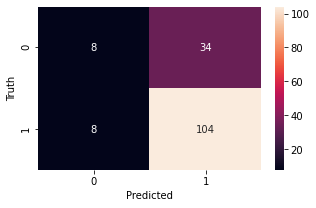




Optimized for recall-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.5
Accuracy :  0.7272727272727273
f1-score :  0.8421052631578948
Recall :  1.0
Sensitivity :  0.0


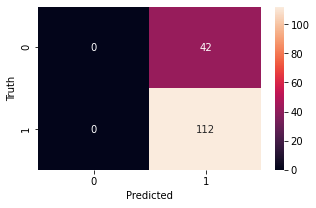




Optimized for specificity-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.5982142857142857
Accuracy :  0.7077922077922078
f1-score :  0.8068669527896996
Recall :  0.8392857142857143
Sensitivity :  0.35714285714285715


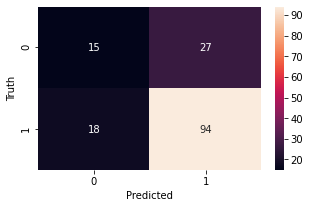

In [15]:
for k,v in grid_results.items():

    print('Optimized for %s-score: -- Confusion Matrix and External Evaluation \n' %(k))
    y_predicted = grid_results[k].predict(X_test)
    cm1 = confusion_matrix(y_test, y_predicted)
    print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_predicted))
    print('Accuracy : ', accuracy_score(y_test, y_predicted))
    print('f1-score : ', f1_score(y_test, y_predicted))
    print('Recall : ' , recall_score(y_test, y_predicted))


    sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity )

    #specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    #print('Specificity : ', specificity)

    # Visualize it as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sn
    plt.figure(figsize=(5,3))
    sn.heatmap(cm1,annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print('\n\n')

### Decision boundry with SVMs' decision function

In [31]:
clf_f1 = SVC(kernel='rbf', C=2.258024691358025, gamma=0.642000491305714)
clf_f1.fit(X_train, y_train)

SVC(C=2.258024691358025, gamma=0.642000491305714)

In [32]:
score, cm = validate_against_test(clf_f1, X_train, y_train)
score

{'Balanced Accuracy': 0.9956140350877194,
 'Accuracy': 0.9956140350877193,
 'ROC_AUC': 0.9956140350877194,
 'f1_score': 0.9956043956043956,
 'recall_score': 0.993421052631579,
 'specificity_score': 0.9978070175438597,
 'precision_score': 0.9977973568281938}

In [33]:
clf_recall = SVC(kernel='rbf', C=0.1, gamma=13.06863127190338)
clf_recall.fit(X_train, y_train)

SVC(C=0.1, gamma=13.06863127190338)

In [34]:
score, cm = validate_against_test(clf_recall, X_train, y_train)
score

{'Balanced Accuracy': 1.0,
 'Accuracy': 1.0,
 'ROC_AUC': 1.0,
 'f1_score': 1.0,
 'recall_score': 1.0,
 'specificity_score': 1.0,
 'precision_score': 1.0}

In [23]:
clf_spec = SVC(kernel='rbf', C=10.187791495198903, gamma=0.09763401412386322)
clf_spec.fit(X_train, y_train)

SVC(C=10.187791495198903)

In [35]:
score, cm = validate_against_test(clf_spec, X_train, y_train)
score

{'Balanced Accuracy': 0.9758771929824561,
 'Accuracy': 0.9758771929824561,
 'ROC_AUC': 0.9758771929824561,
 'f1_score': 0.9755555555555556,
 'recall_score': 0.9627192982456141,
 'specificity_score': 0.9890350877192983,
 'precision_score': 0.9887387387387387}

In [48]:
a = clf_spec.decision_function(X_train)
((0 < a[y_train == 1]) & (a[y_train == 1] < 1000)).sum()

439

In [49]:
a[y_train == 1].sum()

525.3077919891476

In [19]:
''' Plots the seperation plane 
      Args:
           LinearSVC: An LinearSVC instance that was previously fitted (.fit())
'''
def show_linearSVC_class_separation(ra, linearSVC: 'LinearSVC', X_test, y_test, hohe, title):

    y_decision_score = linearSVC.decision_function(X_test)

    # getting the score of the truly positive individuals
    y_positive_decision_score = y_decision_score[y_test == 1]

    # getting the score of the truly negative individuals
    y_negative_decision_score = y_decision_score[y_test == 0]

    # get the (min-1) and the (max +1) scores to be sure to include all the scores in the intervals of the histogramme
    _, min_positive = np.modf(y_positive_decision_score.min() - 1)
    _, max_positive = np.modf(y_positive_decision_score.max() + 1)
    positive_bins = np.arange(min_positive, max_positive + 1)

    # get the (min-1) and the (max +1) scores to be sure to include all the scores in the intervals of the histogramme    
    _, min_negative = np.modf(y_negative_decision_score.min() - 1)
    _, max_negative = np.modf(y_negative_decision_score.max() + 1)
    negative_bins = np.arange(min_negative, max_negative + 1)

    # plot the two histograms, alpha (the transparency) is for the overlapping areas
    ra.hist(y_positive_decision_score, bins=positive_bins, alpha=0.5, label='True positives', color='b')
    ra.hist(y_negative_decision_score, bins=negative_bins, alpha=0.5, label='True negatives', color='r')

    ra.plot([-1,-1], [0,hohe], 'g--')
    ra.plot([0,0], [0,hohe], 'g-.')
    ra.plot([1,1], [0,hohe], 'g--')
    ra.set_xlabel('Distance to decision boundary')
    ra.set_ylabel('Nb. of data points')
    ra.xaxis.set_major_locator(MaxNLocator(integer=True))
    ra.yaxis.set_major_locator(MaxNLocator(integer=True))
    ra.set_title(title)
    ra.legend()
    #plt.show()

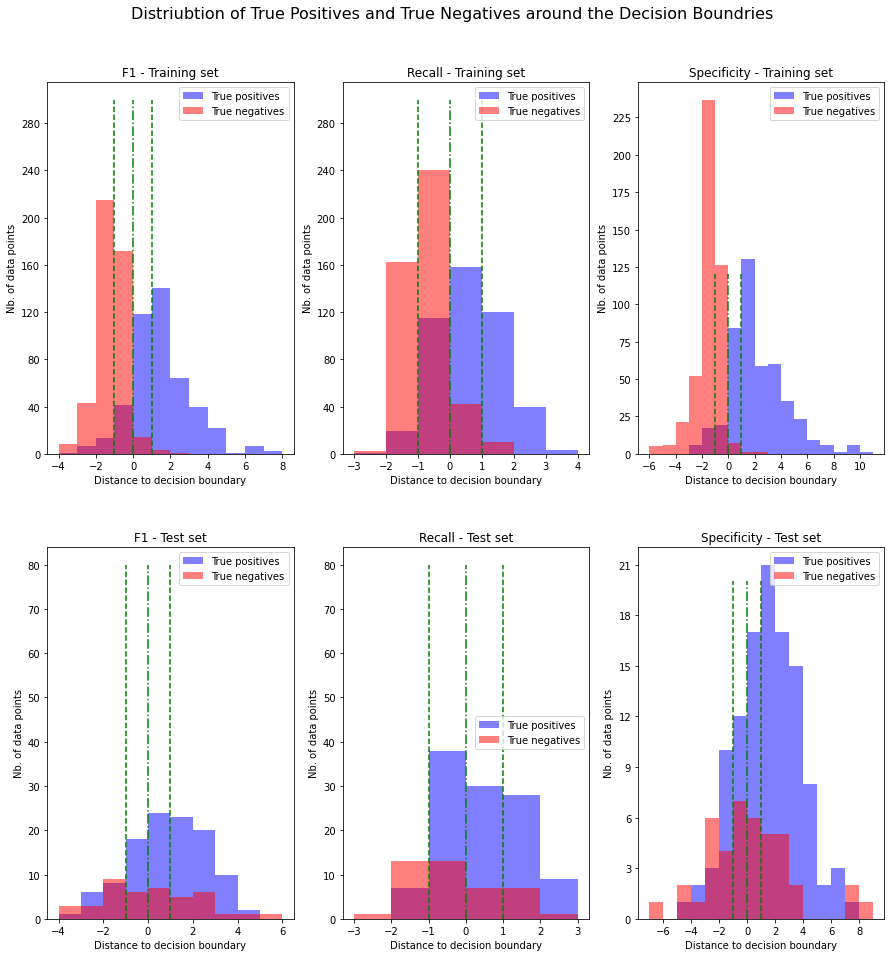

In [20]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(2,3 , figsize=(15,15))
ax = ax.flatten()

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)
fig.suptitle('Distriubtion of True Positives and True Negatives around the Decision Boundries', fontsize=16, y=0.97)

show_linearSVC_class_separation(ax[0], clf_f1, X_train, y_train, 300, 'F1 - Training set')
show_linearSVC_class_separation(ax[3], clf_f1, X_test, y_test, 80, 'F1 - Test set')
show_linearSVC_class_separation(ax[1], clf_recall, X_train, y_train, 300, 'Recall - Training set')
show_linearSVC_class_separation(ax[4], clf_recall, X_test, y_test, 80, 'Recall - Test set')
show_linearSVC_class_separation(ax[2], clf_spec, X_train, y_train, 120, 'Specificity - Training set')
show_linearSVC_class_separation(ax[5], clf_spec, X_test, y_test, 20, 'Specificity - Test set')